In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from glob import glob


In [2]:
alignment_file = "1.1.1/labels.csv"
graph_file = "../../example/sample_66/assembly.gfa"

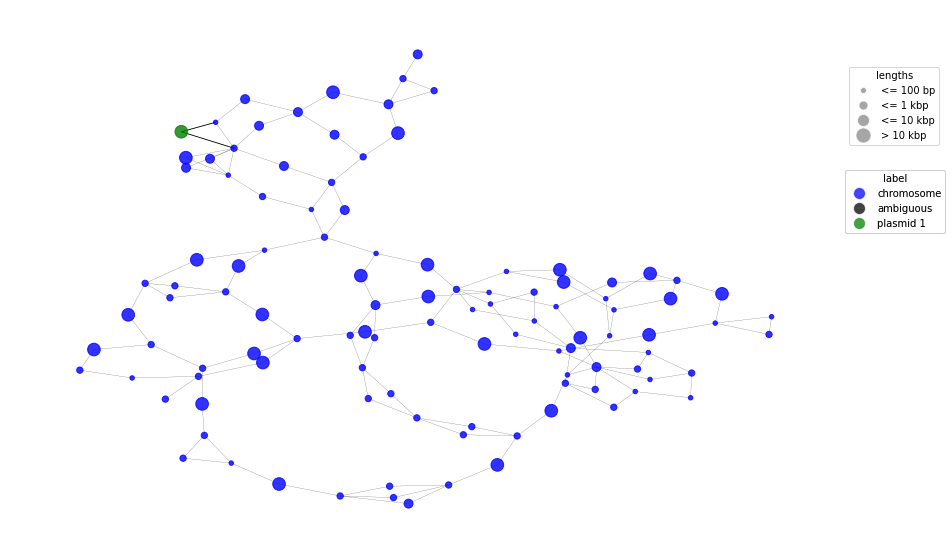

In [3]:

file_ = open(graph_file, "r")
lines = file_.readlines()
file_.close()

df_alignment = pd.read_csv(alignment_file, index_col=0)

# generate dictionary which mappes contig names to plasmid ids
plasmids_df = df_alignment[df_alignment["label"] == "plasmid"]
dict_plasmidContigId_plasmidId = {}
if not plasmids_df.empty:
    # make dict from two columns
    for idx, plasmid_id in enumerate(
        sorted(list(set(plasmids_df["bin_id"])))
    ):
        dict_plasmidContigId_plasmidId[plasmid_id] = idx

dict_contig_length = {}

for line in lines:
    if line.split()[0] == "S":
        dict_contig_length[int(line.split()[1])] = len(line.split()[2])

tuple_node1_node2 = []

for line in lines:
    if line.split()[0] == "L":
        tuple_node1_node2.append((int(line.split()[1]), int(line.split()[3])))

# generate graph

G = nx.Graph()

for tpl in tuple_node1_node2:
    G.add_edge(tpl[0], tpl[1])

# remove self loops
G.remove_edges_from(nx.selfloop_edges(G))
# remove all isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

plasmid_colors = [
    "green",
    "red",
    "purple",
    "orange",
    "brown",
    "pink",
    "olive",
    "cyan",
]

node_sizes = []
node_colors = []
plasmid_nodes = set()
plasmid_contig_ids = set()

for node_ in nx.nodes(G):
    seq_length = dict_contig_length[node_]

    if seq_length <= 100:
        node_sizes.append(20)
    elif seq_length <= 1000:
        node_sizes.append(40)
    elif seq_length <= 10000:
        node_sizes.append(80)
    else:
        node_sizes.append(160)

    try:
        label = df_alignment.loc[node_, "label"]
        if label == "chromosome":
            node_colors.append("blue")
        elif label == "plasmid":
            contig_id = df_alignment.loc[node_, "bin_id"]
            plasmid_contig_ids.add(dict_plasmidContigId_plasmidId[contig_id])
            # take color according to plasmid id
            node_colors.append(
                plasmid_colors[dict_plasmidContigId_plasmidId[contig_id] % 8]
            )
            plasmid_nodes.add(node_)
        elif label == "ambiguous":
            node_colors.append("black")
        else:
            node_colors.append("grey")
    except KeyError:
        node_colors.append("grey")

plasmid_edges = []
for edge in nx.edges(G):
    if edge[0] in plasmid_nodes or edge[1] in plasmid_nodes:
        plasmid_edges.append(edge)

# draw graph

fig, ax = plt.subplots(figsize=(15, 10))

pos = nx.kamada_kawai_layout(G)
nx.draw(
    G, pos=pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, width=0.2
)  # , with_labels = True

# remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

nx.draw_networkx_edges(G, pos, edgelist=plasmid_edges, width=0.8)

# custom legends
legend1_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="<= 100 bp",
        markerfacecolor="grey",
        markersize=6,
        alpha=0.7,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="<= 1 kbp",
        markerfacecolor="grey",
        markersize=9,
        alpha=0.7,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="<= 10 kbp",
        markerfacecolor="grey",
        markersize=12,
        alpha=0.7,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="> 10 kbp",
        markerfacecolor="grey",
        markersize=15,
        alpha=0.7,
    ),
]

legend2_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="chromosome",
        markerfacecolor="blue",
        markersize=12,
        alpha=0.7,
    )
]
legend2_elements += [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="ambiguous",
        markerfacecolor="black",
        markersize=12,
        alpha=0.7,
    )
]
for i in sorted(list(plasmid_contig_ids)):
    legend2_elements += [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="plasmid " + str(i + 1),
            markerfacecolor=plasmid_colors[i % 8],
            markersize=12,
            alpha=0.7,
        )
    ]

legend_1 = plt.legend(
    handles=legend1_elements,
    loc="upper left",
    bbox_to_anchor=(1, 0.9),
    title="lengths",
)
legend_2 = plt.legend(
    handles=legend2_elements,
    loc="upper left",
    bbox_to_anchor=(0.995, 0.71),
    title="label",
)

plt.gca().add_artist(legend_1)
plt.gca().add_artist(legend_2)

#plt.title("")

#plt.savefig(
#    "../results/figures/graphs/_graph.png", dpi=300, format="png"
#)
plt.show()
plt.clf()
plt.close()
